In [1]:
import numpy as np
import pandas as pd
import os, glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import fft
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
print(torch.__version__)

Using device: cuda
2.6.0+cu118


In [3]:
df = pd.read_csv('../big_codes_nomask.csv') # reads in codes csv as a mutable df :-) contains message, ecl, code, dft cols
df = df.drop([0])
df['dft'] = df['dft ']

In [4]:
df['dft'] = df['dft ']
df.keys()

Index(['message', 'ecl', 'code', 'dft ', 'dft'], dtype='object')

In [5]:
# parse a colomn with a 2d array of each qr code
df['code_array'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x]).reshape(41, 41))
df['code_oned'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x])) # adds a code_oned column to our df which parses our entries from strs to ints

In [6]:
arrays = np.stack(df['code_array'].values)
average_array = np.mean(arrays, axis=0)

fixedIndx = []
for i in range(41):
    for j in range(41):
        if average_array[i][j] == 1:
            fixedIndx.append((i, j))

fixedIndxAll = []
for i in range(41):
    for j in range(41):
        if average_array[i][j] == 1 or average_array[i][j] == 0:
            fixedIndxAll.append((i, j))





In [7]:
nonFixed = []
for i in range(41):
    for j in range(41):
        if (i,j) not in fixedIndxAll:
            nonFixed.append((i,j))
nonFixed

[(0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (1, 21),
 (1, 22),
 (1, 23),
 (1, 24),
 (1, 25),
 (1, 26),
 (1, 27),
 (1, 28),
 (1, 29),
 (1, 30),
 (1, 31),
 (1, 32),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 20),
 (2, 21),
 (2, 22),
 (2, 23),
 (2, 24),
 (2, 25),
 (2, 26),
 (2, 27),
 (2, 28),
 (2, 29),
 (2, 30),
 (2, 31),
 (2, 32),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 18),
 (3, 19),
 (3, 20),
 (3, 21),
 (3, 22),
 (3, 23),
 (3, 24),
 (3, 25),
 (3, 26),
 (3, 27),
 (3, 28),
 (3, 29),
 (3, 30),
 (3, 31),
 (3, 32),
 (4, 8),

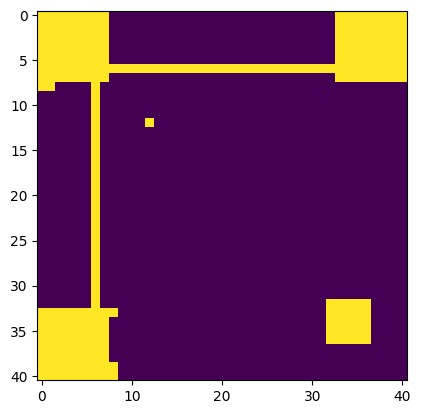

In [8]:
fixedQR = np.zeros((41,41))
for i,j in fixedIndxAll:
    fixedQR[i][j] = 1
fixedQR

plt.imshow(fixedQR)

In [9]:
# grabs a centered subarray of a given array with dimensions (2L+1) by (2L+1)
def get_centered_subarray(array, L):
    # old way -- 
    # L = (L * 2) + 1
    # start = center - (L // 2)
    # end = center + (L + 1) // 2
    n = array.shape[0]
    center = n // 2
    start = center - L
    end = center + 1 + L # start count after our center square
    # Adjust indices to stay within array bounds
    start = max(0, start)
    end = min(n, end)
    return array[start:end, start:end]

In [10]:
# function to split DFT into real and imaginary parts and reshape them
def split_dft(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    imag_part = np.array([c.imag for c in complex_numbers])
    return real_part, imag_part

# apply the function to each row
df['dft_real'], df['dft_imag'] = zip(*df['dft'].apply(split_dft))


In [11]:
# function to take dft string into complex tuple stored as (a, ib)
def combine_dft_full(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    # real_part = zero_pad_right(0.5, real_part)
    imag_part = np.array([c.imag for c in complex_numbers])
    # imag_part = zero_pad_right(0.5, imag_part)
    return np.append(real_part, imag_part)

df['dft_stacked'] = df['dft'].apply(combine_dft_full)

In [12]:
fixed_fft = fft.fft2(fixedQR)

In [13]:
flat = fixed_fft.copy().flatten() # flatten fixed 

# subtracts flattened fixed qr fft from flattened qr fft
def adjust(stacked):
    copy = stacked.copy()
    for i in range(1681): 
        copy[i] -= flat[i].real
        copy[i+1681] -= flat[i].imag # imaginary numbers shifted by 1681 (total len)
    return copy

df['adjusted'] = df['dft_stacked'].apply(adjust)

In [14]:
len(nonFixed)

1408

In [15]:
def adjust_y(flat):
    new = np.array([flat[row * 41 + column] for row, column in nonFixed])
    return new

df['y_adjusted'] = df['code_oned'].apply(adjust_y)


In [16]:
# Features (X) - DFT components
X = np.stack(df['adjusted'].values)  # Shape: (num_samples, 1682) - (flat) total input data

# Labels (y) - QR codes
y = np.stack(df['y_adjusted'].values)  # Shape: (num_samples, 841) - (flat)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # decide on a rseed of 42 and a set set of 20%

In [17]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super(Model, self).__init__()
        input_size = ((((L*2)+1)**2)*2)  # Matches the tf.keras InputLayer
        output_size = 1396  # mathces number of non fixed pixels
        
        self.fc = nn.Linear(input_size, output_size)  # Single-layer


    def forward(self, x):
        x = self.fc(x)

        return x

In [18]:
def evaluate_model(model, X_test, y_test, num_samples=5):
    """
    evaluates the trained model on the test set and displays a few samples with their predictions.

    parameters:
    - model: The trained TensorFlow/Keras model.
    - X_test: The input features for the test set (shape: (num_samples, 1682)).
    - y_test: The true labels for the test set (shape: (num_samples, 841)).
    - num_samples: The number of test samples to display.

    returns:
    - accuracy: The overall accuracy of the model on the test set.
    """
    # make predictions on the test set
    predictions = model.predict(X_test)
    
    # binarize the predictions (0 or 1)
    predictions_binarized = (predictions > 0.5).astype(np.int32)
    
    # calculate accuracy
    correct_predictions = np.sum(predictions_binarized == y_test)
    total_elements = y_test.size
    accuracy = correct_predictions / total_elements
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

        
    return accuracy

In [19]:
df['dft_rolled'] = df['adjusted'].apply(lambda x: np.roll(x.reshape(41,41,2), shift=(20, 20), axis=(0, 1)))

In [20]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Define Model Class
class Model(nn.Module):
    def __init__(self, L):
        super(Model, self).__init__()
        input_size = ((((L*2)+1)**2)*2)  # Adjusts input size for L
        output_size = 1408  # Matches TensorFlow model
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)  # No activation for regression

# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

def evaluate_model(model, X_test, y_test, num_samples=5):
    """
    Evaluates the trained PyTorch model on the test set and displays a few samples with their predictions.

    Parameters:
    - model: The trained PyTorch model.
    - X_test: The input features for the test set (shape: (num_samples, 1682)).
    - y_test: The true labels for the test set (shape: (num_samples, 841)).
    - num_samples: The number of test samples to display.

    Returns:
    - accuracy: The overall accuracy of the model on the test set.
    """
    
    # Ensure model is in evaluation mode
    model.eval()

    # Convert test data to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    with torch.no_grad():  # No gradient calculation needed
        predictions = model(X_test_tensor)  # Get model predictions

    # Apply threshold to binarize (0 or 1)
    predictions_binarized = (predictions > 0.5).int()

    # Compute accuracy
    correct_predictions = (predictions_binarized == y_test_tensor).sum().item()
    total_elements = y_test_tensor.numel()
    accuracy = correct_predictions / total_elements

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Device Setup (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Main Loop Over L Values
L = 10
stat = []
for L in range(10, 0, -1):
    # Extract L features
    df['L'] = df['dft_rolled'].apply(lambda x: get_centered_subarray(x, L).flatten())

    # Convert features to numpy arrays
    X = np.stack(df['L'].values)  # Shape: (num_samples, ((L*2)+1)*2)
    y = np.stack(df['y_adjusted'].values)  # Assuming `df['target']` contains labels

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize Model, Optimizer, and Loss Function
    model = Model(L).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()  # Assuming a regression task

    # Train Model
    train_model(model, train_loader, criterion, optimizer, epochs=25)

    # Evaluate Model
    accuracy = evaluate_model(model, X_test, y_test)
    stat.append((L, accuracy))

    print(stat)


Epoch 1/25, Loss: 23.0822
Epoch 2/25, Loss: 11.9492
Epoch 3/25, Loss: 6.4626
Epoch 4/25, Loss: 3.8366
Epoch 5/25, Loss: 2.4213
Epoch 6/25, Loss: 1.5847
Epoch 7/25, Loss: 1.1388
Epoch 8/25, Loss: 0.8097
Epoch 9/25, Loss: 0.6149
Epoch 10/25, Loss: 0.4953
Epoch 11/25, Loss: 0.3945
Epoch 12/25, Loss: 0.3399
Epoch 13/25, Loss: 0.2902
Epoch 14/25, Loss: 0.2459


KeyboardInterrupt: 

In [21]:
#fixed L

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Define Model Class
# Define Model Class
class Model(nn.Module):
    def __init__(self, L):
        super(Model, self).__init__()
        input_size = ((((L*2)+1)**2)*2)  # Adjusts input size for L
        output_size = 1408  # Matches TensorFlow model
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)  # No activation for regression

# Training Loop (Records Accuracy Every 5 Epochs)
def train_model(model, train_loader, criterion, optimizer, X_test, y_test, epochs=25):
    model.train()
    stat = []  # Store accuracy every 5 epochs
    
    for epoch in range(1, epochs + 1):
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Evaluate every 5 epochs
        if epoch % 5 == 0:
            accuracy = evaluate_model(model, X_test, y_test)
            stat.append((epoch, accuracy))
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}")

    return stat

# Evaluation Function
def evaluate_model(model, X_test, y_test):
    model.eval()
    
    # Convert to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(X_test_tensor)
    
    # Binarize predictions (threshold at 0.5)
    predictions_binarized = (predictions > 0.5).int()

    # Compute accuracy
    correct_predictions = (predictions_binarized == y_test_tensor).sum().item()
    total_elements = y_test_tensor.numel()
    accuracy = correct_predictions / total_elements

    return accuracy

# Device Setup (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Fixed L**
L = 6

# Extract L features once (no loop needed)
df['L'] = df['dft_rolled'].apply(lambda x: get_centered_subarray(x, L).flatten())

# Convert features to numpy arrays
X = np.stack(df['L'].values)  # Shape: (num_samples, ((L*2)+1)*2)
y = np.stack(df['y_adjusted'].values)  # Assuming `df['y_adjusted']` contains labels

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize Model, Optimizer, and Loss Function
model = Model(L).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Assuming a regression task

# Train and Collect Accuracy Every 5 Epochs
stat = train_model(model, train_loader, criterion, optimizer, X_test, y_test, epochs=200)

print("Final Accuracy Stats:", stat)


Epoch 5/200, Loss: 2.7366, Test Accuracy: 0.5421
Epoch 10/200, Loss: 0.4982, Test Accuracy: 0.6178
Epoch 15/200, Loss: 0.2253, Test Accuracy: 0.6998
Epoch 20/200, Loss: 0.1765, Test Accuracy: 0.7457
Epoch 25/200, Loss: 0.1606, Test Accuracy: 0.7643
Epoch 30/200, Loss: 0.1578, Test Accuracy: 0.7713
Epoch 35/200, Loss: 0.1534, Test Accuracy: 0.7739
Epoch 40/200, Loss: 0.1520, Test Accuracy: 0.7752
Epoch 45/200, Loss: 0.1522, Test Accuracy: 0.7757
Epoch 50/200, Loss: 0.1508, Test Accuracy: 0.7760
Epoch 55/200, Loss: 0.1515, Test Accuracy: 0.7760
Epoch 60/200, Loss: 0.1515, Test Accuracy: 0.7760
Epoch 65/200, Loss: 0.1514, Test Accuracy: 0.7757
Epoch 70/200, Loss: 0.1523, Test Accuracy: 0.7755
Epoch 75/200, Loss: 0.1512, Test Accuracy: 0.7761
Epoch 80/200, Loss: 0.1513, Test Accuracy: 0.7759
Epoch 85/200, Loss: 0.1512, Test Accuracy: 0.7761
Epoch 90/200, Loss: 0.1505, Test Accuracy: 0.7760
Epoch 95/200, Loss: 0.1510, Test Accuracy: 0.7758
Epoch 100/200, Loss: 0.1526, Test Accuracy: 0.7763


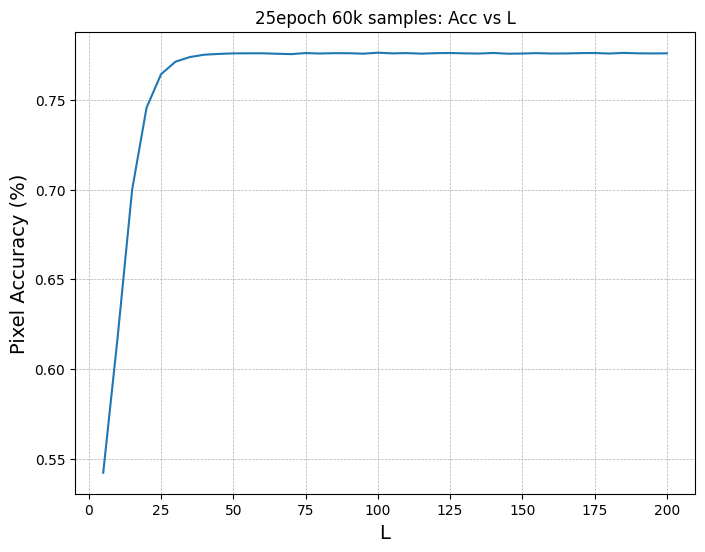

In [22]:
#l graph
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel('L', fontsize=14)
ax.set_ylabel('Pixel Accuracy (%)', fontsize=14)
ax.set_title('25epoch 60k samples: Acc vs L')
ax.plot([st[0] for st in stat], [st[1] for st in stat]) # plots accuracy vs L -- we can add labels later!

In [23]:
fig.savefig('torch_graphs/bigqr_L6_epoch_vs_accuracy_60k_nohidden_nomasks_longmessage_ torch.png', dpi=300)

In [24]:
stat

[(5, 0.5420862926136364),
 (10, 0.617786103219697),
 (15, 0.6998217921401515),
 (20, 0.7456899857954545),
 (25, 0.7643015506628787),
 (30, 0.7713206676136364),
 (35, 0.7739155421401516),
 (40, 0.7752131273674242),
 (45, 0.7756541193181818),
 (50, 0.7759568536931818),
 (55, 0.7759858546401515),
 (60, 0.7759942589962121),
 (65, 0.775745146780303),
 (70, 0.7755287642045454),
 (75, 0.7761222182765152),
 (80, 0.7758819247159091),
 (85, 0.7760657552083333),
 (90, 0.776038115530303),
 (95, 0.7757746212121213),
 (100, 0.7763160511363636),
 (105, 0.7759640743371212),
 (110, 0.7760969460227273),
 (115, 0.7757958096590909),
 (120, 0.776069365530303),
 (125, 0.7761616358901515),
 (130, 0.7759686908143939),
 (135, 0.7758567116477273),
 (140, 0.7761834161931818),
 (145, 0.7757640269886363),
 (150, 0.7758674242424243),
 (155, 0.7760850497159091),
 (160, 0.7758735203598485),
 (165, 0.775905303030303),
 (170, 0.776083037405303),
 (175, 0.7761706321022728),
 (180, 0.7758706202651515),
 (185, 0.776220348

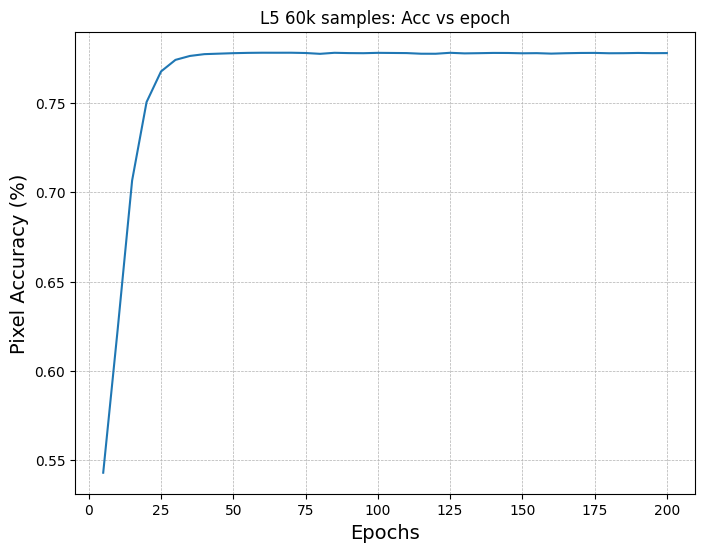

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Pixel Accuracy (%)', fontsize=14)
ax.set_title('L5 60k samples: Acc vs epoch')
ax.plot([st[0] for st in stat], [st[1] for st in stat]) # plots accuracy vs L -- we can add labels later!

In [52]:
stat = [(5, 0.653810689345359), (10, 0.7577413740249024), (15, 0.805825786729803), (20, 0.8274369970269885), (25, 0.8379219478431206), (30, 0.8446664134529736), (35, 0.8498873793539581), (40, 0.8517204472627857), (45, 0.854814080737893), (50, 0.8563472205619802), (55, 0.8576252588370936), (60, 0.8592826356460612), (65, 0.8604568016796936), (70, 0.8603871518472389), (75, 0.8621917814161715), (80, 0.8629188871065387), (85, 0.8635769454716523), (90, 0.8631585644711626), (95, 0.8639448363686842), (100, 0.8645684313218912)]